In [33]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch
from mltrainer import Trainer, TrainerSettings, ReportTypes
import tomllib
import seaborn as sns
import numpy as np
from torch import Tensor
import math
from typing import List, Tuple, Dict, Any, Union
from src import datasets, metrics
import mltrainer
mltrainer.__version__

'0.1.129'

In [3]:


datadir = Path('../data')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

{'ptb': 'heart', 'arrhythmia': 'heart_big'}


In [5]:
trainfile = datadir / (config['arrhythmia'] + '_oversampled_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(PosixPath('../data/heart_big_oversampled_train.parq'),
 PosixPath('../data/heart_big_test.parq'))

Load the data

In [6]:
# load data in dataframes
train_df = pd.read_parquet(trainfile)
test_df = pd.read_parquet(testfile)

In [7]:
traindataset = datasets.HeartDataset1D(trainfile, target="target")
testdataset = datasets.HeartDataset1D(testfile, target="target")
traindataset, testdataset

# moving to mps device crashes the jupyter kernel

(Heartdataset (len 144942), Heartdataset (len 21892))

Visualise it as 1D data

Set up the streamer

In [9]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(4529, 684)

Positional encoding to use with the transformer.

In [10]:


class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_seq_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_seq_len, d_model)
        # batch, seq_len, d_model
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

Note, the layers have different assumptions about the data structure:
- streamer:         (batch, seq_len, channels)
- conv1d:           (batch, channels, seq_len)
- pos_encoding:     (batch, seq_len, channels)
- gru (batchfirst): (batch, seq_len, channels)
- attention:        (batch, seq_len, channels)

As you can see, its just the conv1d layer that expects channels as the second dimension. Using a conv1d layer you
will need to transpose the dimensions, I will show how to do that in the Transformer `forward` method.

Again, the strategy of creating a block helps us stack the architecture more easily.

In [42]:
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout):
        # feel free to change the input parameters of the constructor
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
        )
        self.ff = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size)

    def forward(self, x):
        identity = x.clone() # skip connection
        x, _ = self.attention(x, x, x)
        x = self.layer_norm1(x + identity) # Add & Norm skip
        identity = x.clone() # second skip connection
        x = self.ff(x)
        x = self.layer_norm2(x + identity) # Add & Norm skip
        return x

class Transformer(nn.Module):
    def __init__(
        self,
        config: dict,
    ) -> None:
        super().__init__()
        self.conv1d = nn.Conv1d(
            in_channels=1,
            out_channels=config["hidden"],
            kernel_size=3,
            stride=2,
            padding=1,
        )
        self.pos_encoder = PositionalEncoding(config["hidden"], config["dropout"])

        # Create multiple transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(config["hidden"], config["num_heads"], config["dropout"])
            for _ in range(config["num_blocks"])
        ])

        #self.out = nn.Linear(config["hidden"], config["output"])
        #extra dense layers
        self.out = nn.Sequential(
            nn.Linear(config["hidden"], config["hidden"]//2),
            nn.ReLU(),
            nn.Dropout(config["dropout"]),
            nn.Linear(config["hidden"]//2, config["output"]),
        )

    def forward(self, x: Tensor) -> Tensor:
        # streamer:         (batch, seq_len, channels)
        # conv1d:           (batch, channels, seq_len)
        # pos_encoding:     (batch, seq_len, channels)
        # attention:        (batch, seq_len, channels)
        x = self.conv1d(x.transpose(1, 2)) # flip channels and seq_len for conv1d
        x = self.pos_encoder(x.transpose(1, 2)) # flip back to seq_len and channels

        # Apply multiple transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)

        x = x.mean(dim=1) # Global Average Pooling
        x = self.out(x)
        return x

In [12]:
from src import models
config = {
    "hidden": 128,
    "dropout": 0.1,
    "output": 5,
    "num_heads": 8,
    "num_blocks": 1,
}
print(config)
model = models.Transformer(config)

{'hidden': 128, 'dropout': 0.1, 'output': 5, 'num_heads': 8, 'num_blocks': 1}


Model 1D
Transofrmer block with 16 hidden units
Dropout  0.1
heads 4

Transformer is 1D conv
1 block
1 positional encoding

In [13]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 192, 1]), torch.Size([32]))

In [14]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [15]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("Transformer")

<Experiment: artifact_location='/Users/francesca/code_repo/MADS-exam-25/notebooks/mlruns/2', creation_time=1736969121395, experiment_id='2', last_update_time=1736969121395, lifecycle_stage='active', name='Transformer', tags={}>

In [16]:
# Check if MPS is available
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('MPS is available')
else:
    device = torch.device('cpu')

print(f"Model is on device: {next(model.parameters()).device}")


MPS is available


In [51]:
from sklearn.utils.class_weight import compute_class_weight
classes = train_df.target.unique()
class_weights = compute_class_weight('balanced', classes=classes, y=train_df.target)
class_weights_tensor = torch.tensor(class_weights).float().to(device)


In [26]:
import logging
from mltrainer import TrainerSettings, ReportTypes

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

model = model.to(device)

with mlflow.start_run():
    
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        device=device,
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=len(trainstreamer) //5,
        valid_steps=len(teststreamer) //5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn.to(device),
        optimizer=optimizer,
        traindataloader=((x.to(device), y.to(device)) for x, y in trainstreamer.stream()),
        validdataloader=((x.to(device), y.to(device)) for x, y in teststreamer.stream()),
        scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
        )
    trainer.loop()

100%|██████████| 905/905 [00:09<00:00, 92.40it/s]
INFO:__main__:Epoch 0 train 0.1720 test 2.9297 metric ['0.4239', '0.4239', '0.1856', '0.4239', '0.2441']
100%|██████████| 905/905 [00:09<00:00, 93.99it/s]
INFO:__main__:Epoch 1 train 0.1606 test 4.3845 metric ['0.3419', '0.3419', '0.1427', '0.3419', '0.2053']
100%|██████████| 905/905 [00:09<00:00, 94.20it/s]
INFO:__main__:Epoch 2 train 0.1469 test 5.1491 metric ['0.4216', '0.4216', '0.1729', '0.4216', '0.2223']
100%|██████████| 905/905 [00:09<00:00, 93.36it/s]
INFO:__main__:Epoch 3 train 0.1354 test 3.9765 metric ['0.2569', '0.2569', '0.1381', '0.2569', '0.2028']
100%|██████████| 905/905 [00:09<00:00, 92.80it/s]
INFO:__main__:Epoch 4 train 0.1127 test 6.9615 metric ['0.2518', '0.2518', '0.1175', '0.2518', '0.1957']
100%|██████████| 905/905 [00:09<00:00, 92.54it/s]
INFO:__main__:Epoch 5 train 0.1097 test 8.4230 metric ['0.3440', '0.3440', '0.1447', '0.3440', '0.2068']
100%|██████████| 905/905 [00:09<00:00, 91.75it/s]
INFO:__main__:Epoch 

In [52]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
#loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
model = model.to(device)

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        device=device,
        epochs=30,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=len(trainstreamer) //5,
        valid_steps=len(teststreamer) //5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        #scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "ReduceLROnPlateau")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        #traindataloader=trainstreamer.stream(),
        #validdataloader=teststreamer.stream(),
        traindataloader=((x.to(device), y.to(device)) for x, y in trainstreamer.stream()),
        validdataloader=((x.to(device), y.to(device)) for x, y in teststreamer.stream()),
        scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
        
        )
    trainer.loop()

2025-01-18 23:57:24.709 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D/20250118-235724
100%|██████████| 547/547 [00:09<00:00, 55.10it/s]
2025-01-18 23:57:35.752 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.2292 test 4.6028 metric ['0.1117', '0.1117', '0.0629', '0.1117', '0.2718']
100%|██████████| 547/547 [00:09<00:00, 55.21it/s]
2025-01-18 23:57:46.802 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.1967 test 2.6533 metric ['0.6723', '0.6723', '0.2986', '0.6723', '0.3949']
100%|██████████| 547/547 [00:09<00:00, 55.01it/s]
2025-01-18 23:57:57.846 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.1866 test 3.8764 metric ['0.3389', '0.3389', '0.1814', '0.3389', '0.3312']
100%|██████████| 547/547 [00:09<00:00, 54.98it/s]
2025-01-18 23:58:08.936 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1793 test 3.3653 metric ['0.7135', '0.7135', '0.2974', '0.7135', '0.3749']
100%|██████████| 547/547 [00:09<00:00, 55.15it

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

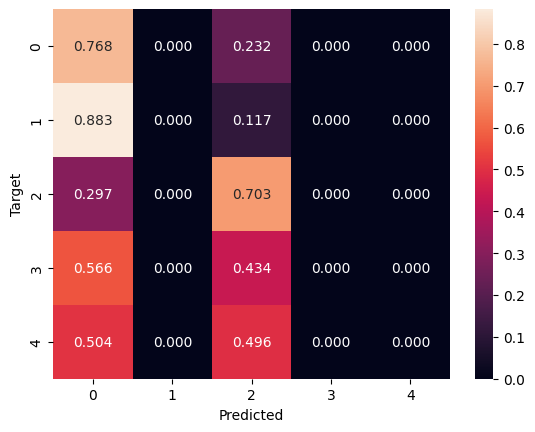

In [57]:
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    X, y = X.to(device), y.to(device)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

In [ ]:
# F1 score computation during training
def compute_f1_score(predictions, labels):
    # Assuming predictions are logits and labels are integers
    pred_labels = torch.argmax(predictions, dim=1)
    return f1_score(labels.cpu(), pred_labels.cpu(), average='macro')

In [59]:
# trainer without class weights + ReduceLROnPlateau scheduler
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=30,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=len(trainstreamer) //5,
        valid_steps=len(teststreamer) //5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.7, "patience": 4},
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
        )
    trainer.loop()

2025-01-19 15:38:15.313 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D/20250119-153815
100%|██████████| 905/905 [00:40<00:00, 22.54it/s]
2025-01-19 15:38:57.595 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.6184 test 0.3078 metric ['0.9113', '0.9113', '0.6949', '0.9113', '0.7703']
100%|██████████| 905/905 [00:41<00:00, 22.05it/s]
2025-01-19 15:39:40.785 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.4570 test 0.3875 metric ['0.8805', '0.8805', '0.6473', '0.8805', '0.7682']
100%|██████████| 905/905 [00:41<00:00, 21.97it/s]
2025-01-19 15:40:24.163 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.4244 test 0.2981 metric ['0.9060', '0.9060', '0.6960', '0.9060', '0.8153']
100%|██████████| 905/905 [00:41<00:00, 21.79it/s]
2025-01-19 15:41:07.839 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.3901 test 0.2658 metric ['0.9207', '0.9207', '0.7322', '0.9207', '0.8374']
100%|██████████| 905/905 [00:41<00:00, 21.71it

{'hidden': 256, 'dropout': 0.1, 'output': 5, 'num_heads': 4, 'num_blocks': 2}
test_results=[0.961 0.691 0.917 0.545 0.978]


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

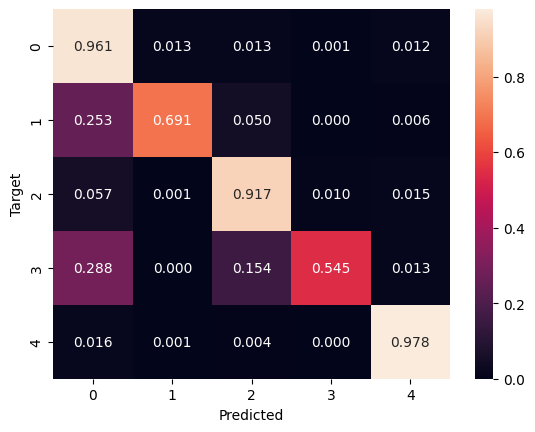

In [60]:
import seaborn as sns
import numpy as np


y_true = []
y_pred = []
#model = model.to("cpu")

#testdata = [(x.to(device), y.to(device)) for x, y in teststreamer.stream()]
testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
print(config)
print(f'test_results={np.round(cfm[cfm > 0.3], 3)}')
plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

In [ ]:
# Check if MPS is available
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('MPS is available')
else:
    device = torch.device('cpu')

print(f"Model is on device: {next(model.parameters()).device}")

In [56]:
#train with mps device

config = {
    "hidden": 256,
    "dropout": 0.1,
    "output": 5,
    "num_heads": 4,
    "num_blocks": 2,
}
print(config)
model = models.Transformer(config)


#loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
#model = model.to(device)

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        device=device,
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=len(trainstreamer) //5,
        valid_steps=len(teststreamer) //5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        #scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "ReduceLROnPlateau")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        device = device,
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        #traindataloader=((x.to(device), y.to(device)) for x, y in trainstreamer.stream()),
        #validdataloader=((x.to(device), y.to(device)) for x, y in teststreamer.stream()),
        scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
        #scheduler=None,
        
        )
    trainer.loop()

2025-01-19 15:34:30.060 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D/20250119-153430


{'hidden': 256, 'dropout': 0.1, 'output': 5, 'num_heads': 4, 'num_blocks': 2}


100%|██████████| 905/905 [00:18<00:00, 48.84it/s]
2025-01-19 15:34:50.147 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.3211 test 3.0622 metric ['0.6383', '0.6383', '0.2903', '0.6383', '0.4575']
100%|██████████| 905/905 [00:17<00:00, 50.65it/s]
2025-01-19 15:35:09.614 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2194 test 4.3984 metric ['0.7518', '0.7518', '0.2743', '0.7518', '0.3036']
100%|██████████| 905/905 [00:18<00:00, 49.41it/s]
2025-01-19 15:35:29.509 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.1976 test 4.0675 metric ['0.6627', '0.6627', '0.2441', '0.6627', '0.3286']
100%|██████████| 905/905 [00:18<00:00, 48.63it/s]
2025-01-19 15:35:49.677 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1996 test 5.4238 metric ['0.1310', '0.1310', '0.0761', '0.1310', '0.2491']
100%|██████████| 905/905 [00:18<00:00, 48.57it/s]
2025-01-19 15:36:09.905 | INFO     | mltrainer.trainer:report:191 - Epoch 4 train 0.1475 test 3.5949 metric ['0.74

In [57]:
# difference between test and train
test_scores = [float(x) for x in ['0.9727', '0.9727', '0.8755', '0.9727', '0.9323']]
train_scores = [0.982, 0.782, 0.961, 0.78, 0.986]
difference = [test - train for test, train in zip(test_scores, train_scores)]
print(np.round(difference, 3))

def calculate_difference(test_scores_str, train_scores_str):
    test_scores = [float(x) for x in test_scores_str]
    train_scores = [float(x) for x in train_scores_str]
    difference = [test - train for test, train in zip(test_scores, train_scores)]
    return np.round(difference, 3)


[-0.009  0.191 -0.086  0.193 -0.054]


In [32]:
training_results=['0.9547', '0.9547', '0.8328', '0.9547', '0.9014']
test_results=['0.961' '0.691' '0.917' '0.545' '0.978']
print(f'difference: {calculate_difference(training_results, test_results)}')

difference: [-0.014  0.352 -0.106  0.035 -0.075]


test_results=[0.862 0.865 0.569 0.431 0.876 0.988]


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

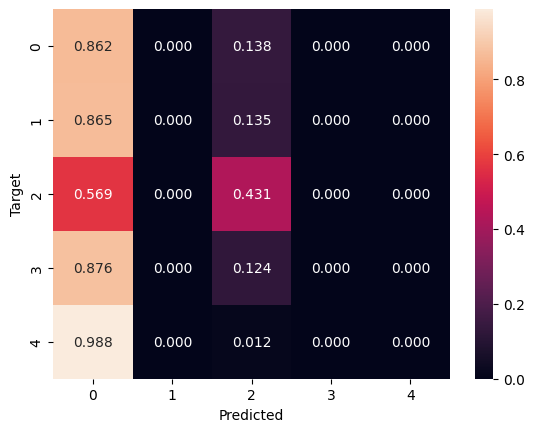

In [ ]:
import seaborn as sns
import numpy as np


y_true = []
y_pred = []
model = model.to("cpu")

#testdata = [(x.to(device), y.to(device)) for x, y in teststreamer.stream()]
testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
print(config)
print(f'test_results=[{np.round(cfm[cfm > 0.3], 3)}]')
plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

In [ ]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=len(trainstreamer) //5,
        valid_steps=len(teststreamer) //5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()

2025-01-15 20:25:21.473 | INFO     | mltrainer.settings:check_path:61 - Created logdir /Users/francesca/code_repo/MADS-exam-25/notebooks/logs/heart1D
2025-01-15 20:25:21.484 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D/20250115-202521
100%|██████████| 547/547 [00:04<00:00, 110.98it/s]
2025-01-15 20:25:27.246 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.6697 test 0.5468 metric ['0.8203', '0.8203', '0.2576', '0.8203', '0.2839']
100%|██████████| 547/547 [00:04<00:00, 111.69it/s]
2025-01-15 20:25:32.709 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.4691 test 0.3629 metric ['0.9046', '0.9046', '0.5638', '0.9046', '0.5641']
100%|██████████| 547/547 [00:04<00:00, 111.83it/s]
2025-01-15 20:25:38.163 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.3797 test 0.3620 metric ['0.8989', '0.8989', '0.5795', '0.8989', '0.5814']
100%|██████████| 547/547 [00:04<00:00, 111.29it/s]
2025-01-15 20:25:43.637 | INFO     | mltrainer.trai

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

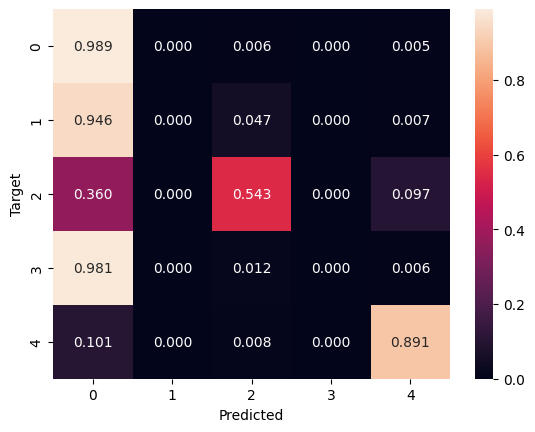

In [16]:


y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

In [20]:
from src import models
config = {
    "hidden": 32,
    "dropout": 0.1,
    "output": 5,
    "num_heads": 4,
    "num_blocks": 2,
}
model = models.Transformer(config)

In [21]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=len(trainstreamer) //5,
        valid_steps=len(teststreamer) //5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()

2025-01-16 10:05:17.764 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D/20250116-100517
100%|██████████| 547/547 [00:10<00:00, 51.50it/s]
2025-01-16 10:05:29.335 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.5582 test 0.3087 metric ['0.9230', '0.9230', '0.6780', '0.9230', '0.6790']
100%|██████████| 547/547 [00:10<00:00, 50.81it/s]
2025-01-16 10:05:41.094 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2968 test 0.2268 metric ['0.9350', '0.9350', '0.7091', '0.9350', '0.7120']
100%|██████████| 547/547 [00:10<00:00, 50.22it/s]
2025-01-16 10:05:52.936 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2443 test 0.1929 metric ['0.9472', '0.9472', '0.7601', '0.9472', '0.7742']
100%|██████████| 547/547 [00:10<00:00, 51.75it/s]
2025-01-16 10:06:04.416 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.2131 test 0.1906 metric ['0.9517', '0.9517', '0.7712', '0.9517', '0.7840']
100%|██████████| 547/547 [00:10<00:00, 52.32it

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

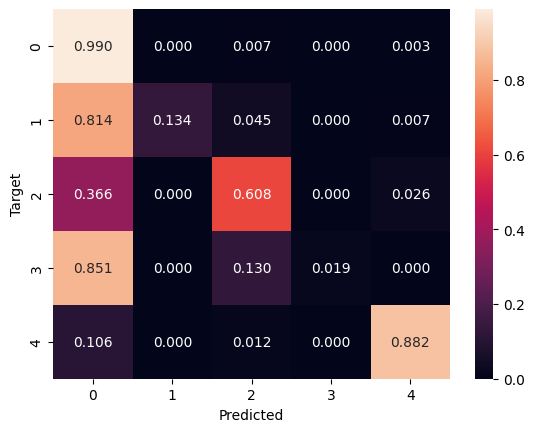

In [19]:
y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

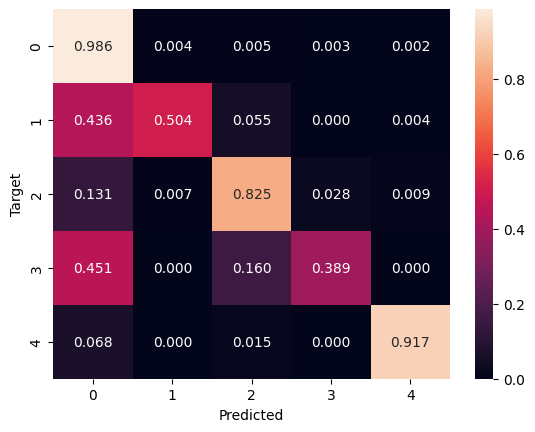

In [22]:
y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")